In [12]:
import os
import re
from lib_log_parse import load_parsed_logs, parse
from typing import Dict, List, Optional
import numpy as np
from lib_constants import log_no_to_region
from model_publication import Publication
from model_retrieval import Retrieval
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from typing import Tuple

sns.set_theme()

In [13]:
def cdf(series: pd.Series) -> pd.DataFrame:
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [14]:
path = "../data/2023-01-24_ignore_gala"

In [15]:
values = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    if os.path.exists(file_path + ".p"):
        print(f"Skipping: {file_path}")
        continue

    values += [[file_path]]

with mp.Pool() as pool:
    pool.map(parse, values)

log_files ['../data/2023-01-24_ignore_gala/ignore-gala-node-2.log']
Loading  ../data/2023-01-24_ignore_gala/ignore-gala-node-2.log
Took 0:00:00.080361
log_files ['../data/2023-01-24_ignore_gala/ignore-gala-node-0.log']
Loading  ../data/2023-01-24_ignore_gala/ignore-gala-node-0.log
Took 0:00:00.087024
log_files ['../data/2023-01-24_ignore_gala/ignore-gala-node-5.log']
Loading  ../data/2023-01-24_ignore_gala/ignore-gala-node-5.log
Took 0:00:00.091150
log_files ['../data/2023-01-24_ignore_gala/ignore-gala-node-4.log']
Loading  ../data/2023-01-24_ignore_gala/ignore-gala-node-4.log
Took 0:00:00.086960
log_files ['../data/2023-01-24_ignore_gala/ignore-gala-node-1.log']
Loading  ../data/2023-01-24_ignore_gala/ignore-gala-node-1.log
Took 0:00:00.106266
Parsing ../data/2023-01-24_ignore_gala/ignore-gala-node-2.log
Resetting retrieval for QmXUD7Uw49DxhUvq1WLTNHRFDjcUZAPJWQGsGoJrVgREig
Resetting retrieval for QmcwutsPdzTEXAwasXDUASyXMXa9KvoS3ZLsiaviU2aRda
Resetting retrieval for QmSSuceT1wwnrm8D2

In [16]:
files = []
for fn in os.listdir(path):
    file_path = os.path.join(path, fn)
    if not os.path.isfile(file_path):
        continue

    if not fn.endswith(".log"):
        continue

    files += [file_path]

pool = mp.Pool(mp.cpu_count())
results = pool.map(load_parsed_logs, list(map(lambda x: [x], files)))


In [17]:
def log_origin(origin: str) -> Optional[int]:
    match = re.search(r".*\/ignore-gala-node-(\d).log", origin)
    if match is None:
        return None

    return int(match.group(1))

def region_from_origin(origin: str) -> str:
    node = log_origin(origin)
    return log_no_to_region[node]


results_by_region = {}

for idx, f in enumerate(files):
    region = region_from_origin(f)

    if not region in results_by_region:
        results_by_region[region] = []
    results_by_region[region] += [results[idx][0]]

In [18]:
df_retrievals_dict = {
    "node": [],
    "region": [],
    "started_at": [],
    "overall_retrieval_duration": [],
    "dht_walks_duration": [],
    "find_first_provider_duration": [],
    "content_fetch_duration": [],
    "find_provider_queries_count": [],
    "has_error": [],
}

In [19]:
publications: List[Publication] = []
retrievals: List[Retrieval] = []
for parsed_log in results:
    for log in parsed_log:
        publications += log.publications
        retrievals += log.retrievals

# Remove all retrievals that are marked as invalid
retrievals = list(
    filter(lambda ret: not ret.marked_as_incomplete, retrievals))
retrievals = list(filter(lambda ret: ret.state != Retrieval.State.DONE_WITHOUT_ASKING_PEERS, retrievals))

for ret in retrievals:
    if ret.stream_opened_at is None or ret.connected_at is None:
        print("skip", ret.stream_opened_at, ret.connected_at)
        continue

    node = log_origin(ret.origin)
    region = region_from_origin(ret.origin)
    # region = region_from_origin(ret.origin)
    if region is None:
        raise Exception("AHH")

    df_retrievals_dict["started_at"] += [ret.dial_started_at]
    df_retrievals_dict["node"] += [node]
    df_retrievals_dict["region"] += [region]
    df_retrievals_dict["has_error"] += [ret.done_retrieving_error is not None]

    overall_retrieval_duration = (ret.done_retrieving_at - ret.retrieval_started_at).total_seconds()
    # simulate peer record retrieval by adding the DHT walk duration
    overall_retrieval_duration += ret.get_dht_walk_duration()
    df_retrievals_dict["overall_retrieval_duration"] += [overall_retrieval_duration]

    # simulate peer record retrieval by adding the DHT walk duration
    dht_walks_duration = 2 * ret.get_dht_walk_duration()
    df_retrievals_dict["dht_walks_duration"] += [dht_walks_duration]

    df_retrievals_dict["find_first_provider_duration"] += [(
                                                                   ret.found_first_provider_at - ret.get_providers_queries_started_at).total_seconds()]
    df_retrievals_dict["content_fetch_duration"] += [(ret.done_retrieving_at - ret.dial_started_at).total_seconds()]
    df_retrievals_dict["find_provider_queries_count"] += [
        len(list(filter(lambda gpq: gpq.started_at > ret.done_retrieving_at, ret.get_providers_queries.values())))]

df_retrievals = pd.DataFrame.from_dict(df_retrievals_dict)

skip None 2023-01-25 04:12:29.128173+00:00


In [20]:
len(df_retrievals)

4991

(0.0, 1.8)

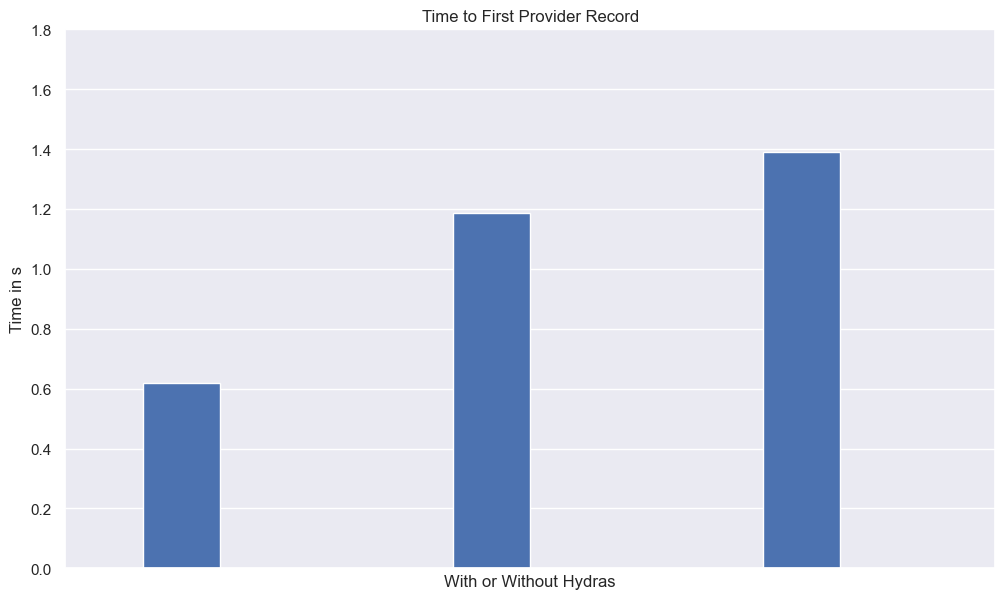

In [21]:
fig, ax = plt.subplots(figsize=[12, 7])

width = 0.25
xticks = []
labels = []
for i, percentile in enumerate([50, 90, 95]):
    with_percentile = np.percentile(df_retrievals["find_first_provider_duration"], percentile)
    ax.bar(i - width / 2, with_percentile, width, label="With Hydras", color="b")

ax.set_title(f"Time to First Provider Record")
ax.set_xlabel("With or Without Hydras")
ax.set_ylabel("Time in s")
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 1.8)

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_47609/4148985411.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = grp.quantile([.5, .9, .95])


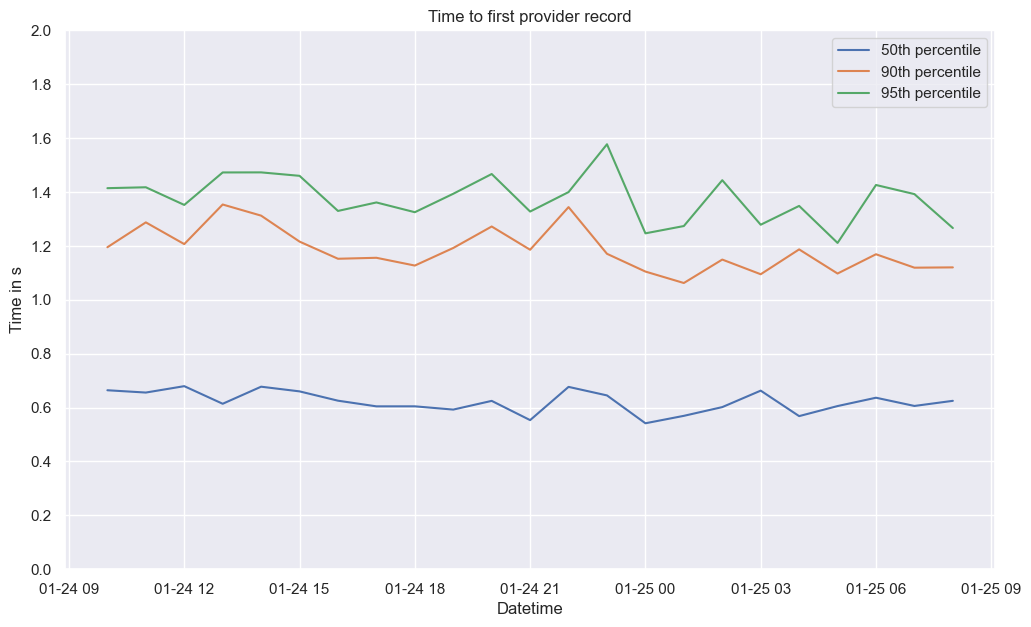

In [22]:
grp = df_retrievals.groupby(by=[df_retrievals.started_at.map(lambda started_at: started_at.replace(minute=0, second=0, microsecond=0))])
grp.find_first_provider_duration.quantile([.5, .9, .95])
df = grp.quantile([.5, .9, .95])
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=[12, 7])

percentiles = [50, 90, 95]
for percentile in percentiles:
    dat = df[df["level_1"] == percentile / 100]
    ax.plot(dat["started_at"], dat["find_first_provider_duration"], label=f"{percentile}th percentile")

ax.set_ylabel("Time in s")
ax.set_xlabel("Datetime")
ax.set_title("Time to first provider record")
ax.set_ylim(0, 2)
ax.set_yticks(np.arange(0, 2.2, 0.2))
ax.legend()